# 📊 Signature Verification — Notebook #6 (Per-Dataset Model Comparison)
This notebook evaluates four models across five signature datasets:
- **MCYT**
- **Chinese**
- **Dutch**
- **German**
- **SVC**

Each dataset is:
- Loaded and cleaned
- Trained using 4 models
- Evaluated using Accuracy, F1 Score, EER, Confusion Matrix
- Compared across datasets in a summary table + chart

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from google.colab import drive
import seaborn as sns
sns.set_style("whitegrid")
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2
    return eer, thresholds[idx]

In [4]:
dataset_info = {
    'MCYT':     ('mcytTraining.txt', 'mcytTesting.txt'),
    'Chinese':  ('chineseTraining.txt', 'chineseTesting.txt'),
    'Dutch':    ('dutchTraining.txt', 'dutchTesting.txt'),
    'German':   ('germanTraining.txt', 'germanTesting.txt'),
    'SVC':      ('svcTraining.txt', 'svcTesting.txt')
}
DATA_DIR = '/content/drive/My Drive/ProjectLabDataset'

In [13]:
results = []

for name, (train_file, test_file) in dataset_info.items():
    print(f"\n📂 Processing dataset: {name}")
    cols = ['ID', 'SigID', 'X', 'Y', 'P', 'al', 'az', 'signatureOrigin']
    train_df = pd.read_csv(f"{DATA_DIR}/{train_file}", names=cols, skiprows=1)
    test_df  = pd.read_csv(f"{DATA_DIR}/{test_file}", names=cols, skiprows=1)

    # Clean both
    for df_label, df in zip(["Train", "Test"], [train_df, test_df]):
        df.columns = df.columns.str.strip()
        for col in ['X', 'Y', 'P']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        before = len(df)
        df.dropna(subset=['X', 'Y', 'P'], inplace=True)
        after = len(df)
        print(f"{name} — {df_label} rows dropped due to NaNs: {before - after}")

        df['label'] = df['signatureOrigin'].map({'Genuine': 1, 'Forged': 0})

    print(f"→ Train: {train_df.shape[0]} rows | Test: {test_df.shape[0]} rows")
    print("✔️ Train class distribution:\n", train_df['label'].value_counts())
    print("✔️ Test class distribution:\n", test_df['label'].value_counts())

    # Keep only X, Y, P
    drop_cols = ['ID', 'SigID', 'signatureOrigin', 'al', 'az']
    X_train = train_df.drop(columns=drop_cols + ['label'])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=drop_cols + ['label'])
    y_test  = test_df['label']

    if X_test.shape[0] == 0 or X_train.shape[0] == 0:
        print("🚨 WARNING: Skipping due to empty data.")
        continue

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=7),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'MLP': MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
    }

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        eer, _ = compute_eer(y_test, y_prob)
        results.append({'Dataset': name, 'Model': model_name, 'Accuracy': acc, 'F1': f1, 'EER': eer})
        print(f"✅ {model_name} — Accuracy: {acc:.3f}, F1: {f1:.3f}, EER: {eer:.3f}")



📂 Processing dataset: MCYT
MCYT — Train rows dropped due to NaNs: 0
MCYT — Test rows dropped due to NaNs: 0
→ Train: 20000 rows | Test: 1000 rows
✔️ Train class distribution:
 label
1    10000
0    10000
Name: count, dtype: int64
✔️ Test class distribution:
 label
1    500
0    500
Name: count, dtype: int64
✅ RandomForest — Accuracy: 0.823, F1: 0.837, EER: 0.175
✅ KNN — Accuracy: 0.803, F1: 0.813, EER: 0.210


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:11:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost — Accuracy: 0.808, F1: 0.821, EER: 0.195
✅ MLP — Accuracy: 0.820, F1: 0.833, EER: 0.178

📂 Processing dataset: Chinese
Chinese — Train rows dropped due to NaNs: 0
Chinese — Test rows dropped due to NaNs: 0
→ Train: 4124 rows | Test: 285 rows
✔️ Train class distribution:
 label
0    2734
1    1390
Name: count, dtype: int64
✔️ Test class distribution:
 label
0    188
1     97
Name: count, dtype: int64
✅ RandomForest — Accuracy: 0.870, F1: 0.781, EER: 0.189
✅ KNN — Accuracy: 0.849, F1: 0.751, EER: 0.217
✅ XGBoost — Accuracy: 0.860, F1: 0.765, EER: 0.204


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:12:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ MLP — Accuracy: 0.881, F1: 0.795, EER: 0.204

📂 Processing dataset: Dutch
Dutch — Train rows dropped due to NaNs: 0
Dutch — Test rows dropped due to NaNs: 0
→ Train: 7056 rows | Test: 502 rows
✔️ Train class distribution:
 label
1    4864
0    2192
Name: count, dtype: int64
✔️ Test class distribution:
 label
1    320
0    182
Name: count, dtype: int64
✅ RandomForest — Accuracy: 0.855, F1: 0.892, EER: 0.177
✅ KNN — Accuracy: 0.855, F1: 0.892, EER: 0.184
✅ XGBoost — Accuracy: 0.847, F1: 0.886, EER: 0.181


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:12:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ MLP — Accuracy: 0.861, F1: 0.897, EER: 0.185

📂 Processing dataset: German
German — Train rows dropped due to NaNs: 0
German — Test rows dropped due to NaNs: 0
→ Train: 1778 rows | Test: 151 rows
✔️ Train class distribution:
 label
1    1066
0     712
Name: count, dtype: int64
✔️ Test class distribution:
 label
1    91
0    60
Name: count, dtype: int64
✅ RandomForest — Accuracy: 0.755, F1: 0.816, EER: 0.246
✅ KNN — Accuracy: 0.788, F1: 0.838, EER: 0.251
✅ XGBoost — Accuracy: 0.742, F1: 0.806, EER: 0.262


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:12:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ MLP — Accuracy: 0.788, F1: 0.842, EER: 0.251

📂 Processing dataset: SVC
SVC — Train rows dropped due to NaNs: 0
SVC — Test rows dropped due to NaNs: 0
→ Train: 5120 rows | Test: 320 rows
✔️ Train class distribution:
 label
1    2560
0    2560
Name: count, dtype: int64
✔️ Test class distribution:
 label
1    160
0    160
Name: count, dtype: int64
✅ RandomForest — Accuracy: 0.706, F1: 0.708, EER: 0.306
✅ KNN — Accuracy: 0.703, F1: 0.704, EER: 0.297
✅ XGBoost — Accuracy: 0.675, F1: 0.694, EER: 0.328


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:12:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ MLP — Accuracy: 0.691, F1: 0.680, EER: 0.294


In [14]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['Dataset', 'F1'], ascending=[True, False])
results_df.reset_index(drop=True, inplace=True)
display(results_df)

,Dataset,Model,Accuracy,F1,EER
0,Chinese,MLP,0.880702,0.795181,0.204157
1,Chinese,RandomForest,0.870175,0.781065,0.188528
2,Chinese,XGBoost,0.859649,0.764706,0.204157
3,Chinese,KNN,0.849123,0.751445,0.217454
4,Dutch,MLP,0.860558,0.896755,0.185216
5,Dutch,RandomForest,0.854582,0.892489,0.176975
6,Dutch,KNN,0.854582,0.891852,0.183705
7,Dutch,XGBoost,0.846614,0.886263,0.181284
8,German,MLP,0.788079,0.841584,0.251374
9,German,KNN,0.788079,0.838384,0.251190


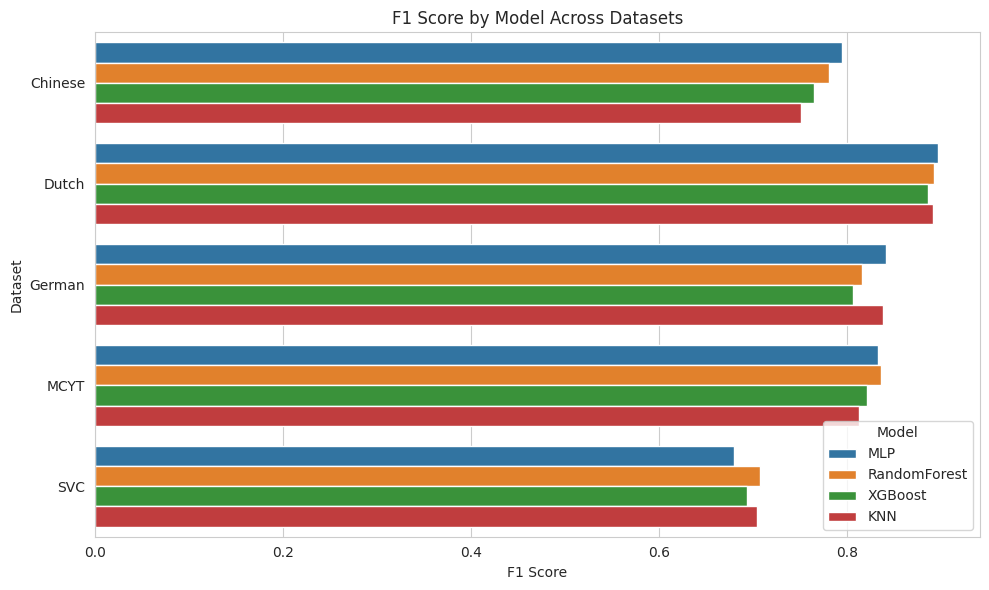

In [15]:
# Plot F1 score comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='F1', y='Dataset', hue='Model', data=results_df)
plt.title('F1 Score by Model Across Datasets')
plt.xlabel('F1 Score')
plt.ylabel('Dataset')
plt.legend(title='Model')
plt.tight_layout()
plt.show()